Perspective warping with subsequent detection of objects and their equivalent ellipses.

 - ROI with NumPy
 - Image rotation
 - Detecting white background: thresholding, then erosion/dilation
 - Edge detection
 - Line detection (Hough transform)
 - Line segments to line vectors (projective geometry)
 - Corner coordinates from lines intersections (cross-product of line vectors)
 - Estimation of a homography matrix
 - Perspective warping
 - Equivalent ellipses from connected components

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
from skimage import data

In [3]:
import os
import sys

LIBRARY_DIRS = [
    os.path.abspath('..'),
    os.path.abspath('../libraries/visionfuncs')
]

for lib_dir in LIBRARY_DIRS:

    if lib_dir not in sys.path:
        sys.path.append(lib_dir)

In [4]:
from visionfuncs import io
from visionfuncs import regions
from visionfuncs import lines
from visionfuncs import viz
from visionfuncs import improc
from visionfuncs import geometry

import faai

## Helper functions

In [5]:
def imshow(im, **kwargs):
    plt.imshow(im, **kwargs)
    plt.axis('off')
    plt.show()

## Load image

In [6]:
im = io.open_image('images/electronics.png', color_transform=cv2.COLOR_BGR2RGB)

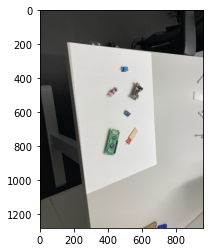

In [7]:
plt.imshow(im)
plt.show()

## Select ROI

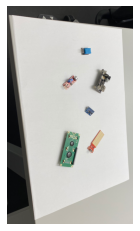

In [8]:
im_roi = im[150:1100, 150:700]

imshow(im_roi)

## Rotate ROI

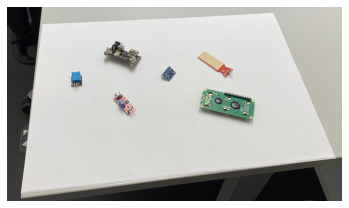

In [9]:
im_roi_r = cv2.rotate(im_roi, cv2.ROTATE_90_COUNTERCLOCKWISE)

imshow(im_roi_r)

## Detect white background

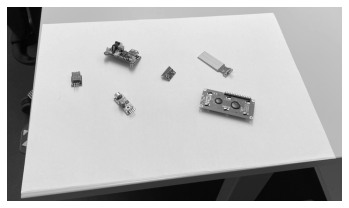

In [10]:
im_gray = cv2.cvtColor(im_roi_r, cv2.COLOR_RGB2GRAY)

imshow(im_gray, cmap='gray')

In [11]:
im_gray.shape

(550, 950)

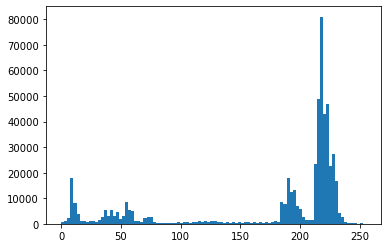

In [12]:
plt.hist(im_gray.ravel(), bins=100)
plt.show()

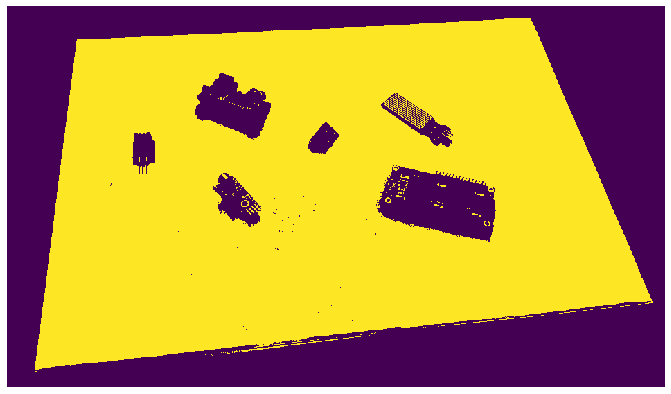

In [13]:
plt.figure(figsize=(18, 7))

im_t = regions.threshold_binary(im_gray, 210)

imshow(im_t, interpolation='none')

## Post-process the binary mask

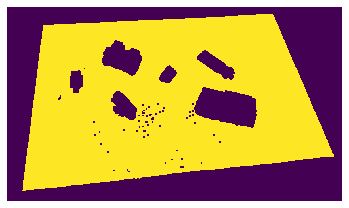

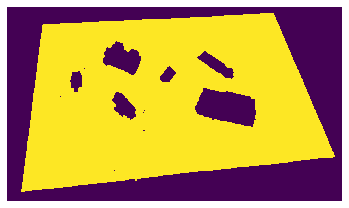

In [14]:
im_eroded = improc.erode(im_t, kernel_size=5)
im_dilated = improc.dilate(im_eroded, kernel_size=5)

plt.figure()
imshow(im_eroded, interpolation='none')

plt.figure()
imshow(im_dilated, interpolation='none')

## Detect edges

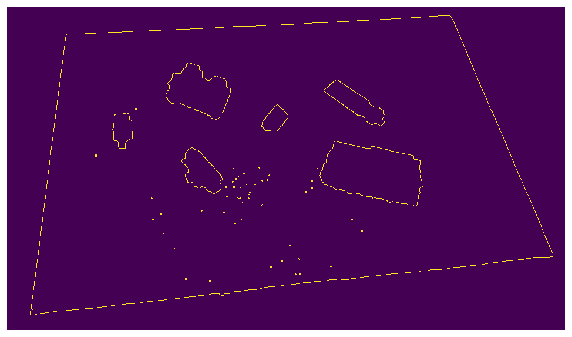

In [15]:
im_edges = cv2.Canny(im_dilated, 20, 100)

plt.figure(figsize=(10, 15))
plt.imshow(im_edges, interpolation='none')
plt.axis('off')
plt.show()

## Detect lines

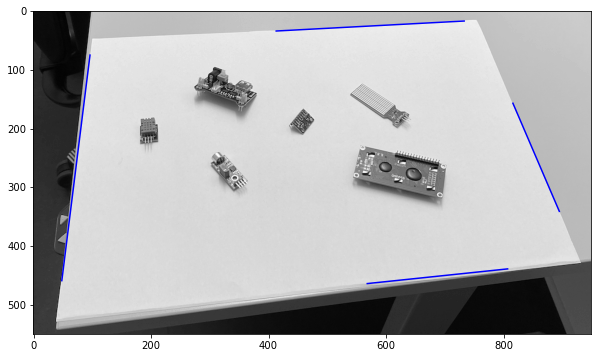

In [16]:
paper_lines = lines.hough_lines(im_edges, 1, np.pi/180, 150, 170, 10)

plt.figure(figsize=(10, 15))
plt.imshow(im_gray, cmap='gray')

for line in paper_lines:
    viz.plot_line(line, color='b')
     
plt.show()

In [17]:
paper_lines

array([[ 48, 459,  96,  75],
       [413,  34, 733,  17],
       [816, 157, 895, 341],
       [568, 464, 807, 439]], dtype=int32)

In [18]:
line_vecs = lines.opencv_points_to_line_vectors(paper_lines)

line_vecs

array([[-9.48991696e-03, -1.18623962e-03,  1.00000000e+00],
       [-9.49667616e-04, -1.78760963e-02,  1.00000000e+00],
       [-1.33584045e-03,  5.73540195e-04,  1.00000000e+00],
       [-1.99846518e-04, -1.91053271e-03,  1.00000000e+00]])

## Find corners of the A3 sheet

In [19]:
def corners_from_lines(opencv_lines):
    
    n_lines = len(opencv_lines)
    
    line_vecs = lines.opencv_points_to_line_vectors(opencv_lines)
    
    res = []
    
    for i in range(n_lines):
        for j in range(i + 1, n_lines):
            
            line_i = line_vecs[i]
            line_j = line_vecs[j]
            
            p_homog = np.cross(line_i, line_j)
            p = geometry.h2e(p_homog)
            
            if p[0] >= 0 and p[1] >= 0:
                res.append(p)
                
    return np.array(res)

In [20]:
cfl = corners_from_lines(paper_lines)

cfl

array([[ 99.04011011,  50.67911915],
       [ 40.47747748, 519.18018018],
       [755.38081796,  15.81101905],
       [931.48534308, 425.9785206 ]])

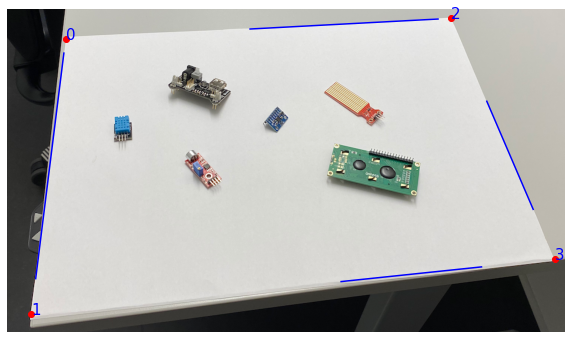

In [21]:
plt.figure(figsize=(10, 15))
plt.imshow(im_roi_r)
plt.axis('off')

for line in paper_lines:
    viz.plot_line(line, color='b')
    
plt.scatter(cfl[:, 0], cfl[:, 1], color='red')

ax = plt.gca()

for i, coord in enumerate(cfl):
    ax.annotate(i, coord, color='blue', size=15)

plt.show()

## Perform perspective warping

Dimension of an A3 paper: 297 x 420 mm

In [22]:
def create_rectangle_points(origin, width, height):
    
    x, y = origin
    
    points = np.array(
        [
            [x, y],
            [x+width, y],
            [x+width, y+height],
            [x, y+height],
        ], 
        dtype=np.float32
    )

    return points

In [23]:
dst_points = create_rectangle_points(origin=(0, 0), width=420, height=297)

dst_points

array([[  0.,   0.],
       [420.,   0.],
       [420., 297.],
       [  0., 297.]], dtype=float32)

In [24]:
src_points = np.array(
    [
        cfl[0],
        cfl[2],
        cfl[3],
        cfl[1]
    ],
    dtype=np.float32
)

In [25]:
src_points

array([[ 99.04011 ,  50.67912 ],
       [755.3808  ,  15.811019],
       [931.48535 , 425.97852 ],
       [ 40.477478, 519.1802  ]], dtype=float32)

In [26]:
M = cv2.getPerspectiveTransform(src_points, dst_points)

In [27]:
M

array([[ 6.18577176e-01,  7.73221438e-02, -6.51825683e+01],
       [ 4.87090583e-02,  9.16876366e-01, -5.12906370e+01],
       [-7.03555826e-05,  8.46652188e-04,  1.00000000e+00]])

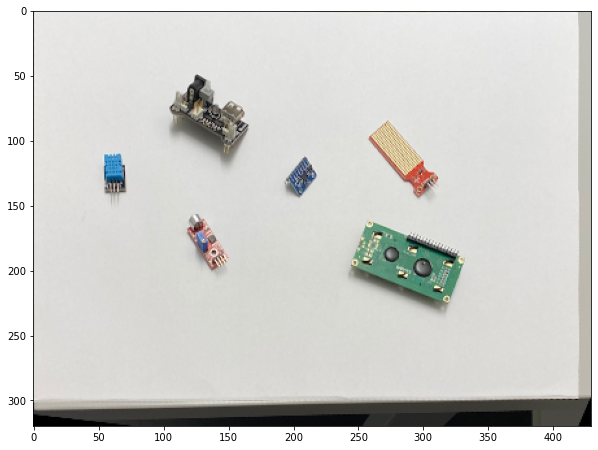

In [28]:
im_warped = cv2.warpPerspective(im_roi_r, M, (430, 320), flags=cv2.INTER_LINEAR)

plt.figure(figsize=(10, 10))
plt.imshow(im_warped)
plt.show()

## Manual tinkering with the homography matrix

In [29]:
M

array([[ 6.18577176e-01,  7.73221438e-02, -6.51825683e+01],
       [ 4.87090583e-02,  9.16876366e-01, -5.12906370e+01],
       [-7.03555826e-05,  8.46652188e-04,  1.00000000e+00]])

In [30]:
src_points

array([[ 99.04011 ,  50.67912 ],
       [755.3808  ,  15.811019],
       [931.48535 , 425.97852 ],
       [ 40.477478, 519.1802  ]], dtype=float32)

In [31]:
faai.h2e(np.dot(M, faai.e2h(src_points[2])))

array([419.9999951 , 296.99999835])

In [32]:
dst_points

array([[  0.,   0.],
       [420.,   0.],
       [420., 297.],
       [  0., 297.]], dtype=float32)

## Equaivalent ellipse

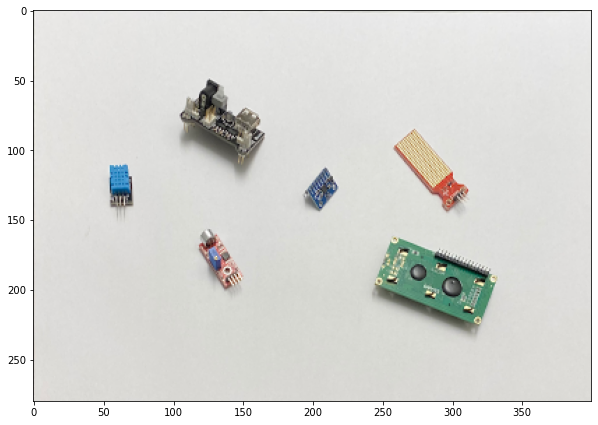

In [33]:
im_warped_for_detection = cv2.warpPerspective(im_roi_r, M, (400, 280), flags=cv2.INTER_LINEAR)

plt.figure(figsize=(10, 10))
plt.imshow(im_warped_for_detection)
plt.show()

In [34]:

def get_mask(im, t=210):
    
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    
    mask = regions.threshold_binary_inv(gray, t)
    
    dilated = improc.dilate(mask, kernel_size=5)
    eroded = improc.erode(dilated, kernel_size=7)
    
    return eroded

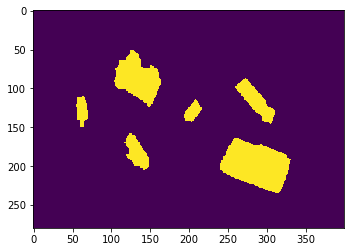

In [35]:
mask_parts = get_mask(im_warped_for_detection)

plt.imshow(mask_parts, interpolation='none')
plt.show()

In [36]:
labels, ccomp_df = regions.find_ccomp(mask_parts)

In [37]:
ccomp_df

,left,top,width,height,area,x,y
0,0,0,400,280,102555,197.726498,138.390649
1,104,51,61,73,2501,134.347861,87.685326
2,260,87,51,59,1165,286.043777,115.889270
3,55,111,16,39,446,62.403587,128.251121
4,194,114,24,30,387,205.007752,130.000000
5,117,158,33,47,827,132.876663,182.626360
6,240,164,92,72,4119,286.442098,198.711580


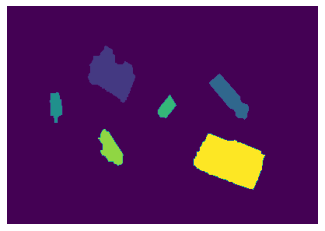

In [38]:
imshow(labels)

In [39]:
parts_df = ccomp_df.iloc[1:]

parts_df

,left,top,width,height,area,x,y
1,104,51,61,73,2501,134.347861,87.685326
2,260,87,51,59,1165,286.043777,115.889270
3,55,111,16,39,446,62.403587,128.251121
4,194,114,24,30,387,205.007752,130.000000
5,117,158,33,47,827,132.876663,182.626360
6,240,164,92,72,4119,286.442098,198.711580


In [40]:
import math
from matplotlib.patches import Ellipse

def viz_ellipses(im, ellipses_data):

    a = plt.subplot(111)

    plt.imshow(im)
    
    for x, y, d1, d2, theta in ellipses_data:
    
        plt.plot(x, y, 'ro')

        ellipse = Ellipse([x, y], d1, d2, math.degrees(theta))
        ellipse.set_alpha(0.5)

        a.add_artist(ellipse)


In [41]:
ellipses_data = []

for i in parts_df.index:
    
    part_mask = np.array(labels == i, dtype=np.uint8)

    ellipse_tuple = regions.region_ellipse_from_moments(part_mask)
    print(i, ellipse_tuple)
    
    ellipses_data.append(ellipse_tuple)

1 (134.34786085565773, 87.68532586965213, 69.49776248119143, 49.11010561603892, 0.810531425934161)
2 (286.04377682403435, 115.88927038626609, 72.45620165441997, 21.36847951199024, 0.8712491865559744)
3 (62.403587443946186, 128.25112107623318, 37.86713034677362, 15.55285614771915, 1.5135868815632016)
4 (205.0077519379845, 130.0, 30.350225887286683, 16.783152165759578, 2.1466122692993426)
5 (132.87666263603387, 182.62636033857316, 49.90911030880193, 22.139744818073982, 1.085974202767927)
6 (286.442097596504, 198.7115804806992, 94.58535986050737, 57.26015797116274, 0.33096735811350114)


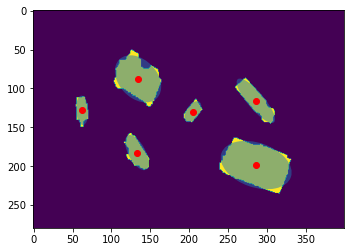

In [42]:
viz_ellipses(mask_parts, ellipses_data)